In [1]:
import os
import sys
# block warnings from printing
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import collections
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from scipy.stats import ttest_ind, ttest_rel
from datetime import datetime

import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean.cm as cmo

# settings
%config InlineBackend.figure_format = 'retina'


In [2]:
### +++ FUNCTIONS +++ ###

## TIME-SERIES MEAN SEASONAL CLIMATOLOGIES ##
def season_mean(ds, calendar='standard'):
    seas_mean = ds.groupby('time.season').mean(dim='time') #sum(dim='time')
    return seas_mean

## ANNUAL SEASONAL MEAN CLIMATOLOGIES ##
def annual_season_mean(ds, calendar='standard'):
    ds_seasonal = {}
    ann_seasonal_mean = {}
    for season in ['DJF','MAM','JJA','SON']:
        # extract data for season
        ds_seasonal[season] = ds.where(ds['time.season'] == season)
        # I'm not sure what this step is doing
        if season == 'DJF':
            ds_seasonal[season] = ds_seasonal[season].shift(time=1)
        # get timeseries of seasonal mean climatologies
        ann_seasonal_mean[season] = ds_seasonal[season].groupby('time.year').mean(dim='time') #sum(dim='time')
        # but, cut first year of DJF timeseries as there is no Dec data from year -1
        if season == 'DJF':
            year_min = ann_seasonal_mean[season].year.min()+1
            year_max = ann_seasonal_mean[season].year.max()
            ann_seasonal_mean[season] = ann_seasonal_mean[season].sel(year=slice(year_min, year_max)) #.isel(year=slice(1,len(ann_seas_mean['DJF'].year)))
    return ann_seasonal_mean


## STATISTICAL SIGNIFICANCE TEST ##
# test with identical sample sizes
def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals

# test with different sample sizes
def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff, diff_mask, ptvals


## WIND SPEED FROM U & V COMPONENTS ##
def windSpd(u,v):
   windSpd=np.sqrt(u**2 + v**2)
   return windSpd

In [3]:
### +++ DATA PATHS +++ ###

runNames=['hadisst', 'E2pt1_PIctrl_restart', 'cam.1senv.cpld', 'cam.sam.1senv.cpld', 'maxtopo_E2pt1_PI_restart_new'] # E2.1 cpld simulations
keys=['obs', 'ctrl', 'cam-only', 'cam+sam', 'max-global'] # product key
diags=['sst','q_925'] # diagnostics

# store file paths in dictionary
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar' # top level data directory
files={}

for i,key in enumerate(keys):
    files[key] = {}
    
    for varn in diags:
        if key in ['obs']:
            if varn in ['sst']:
                files[key][varn] = f'{dpath0}/obs_data/hadisst.gn.timeseries.1870-2020.nc'
            elif varn in ['q_925']:
                files[key][varn] = f'{dpath0}/obs_data/merra2/merra2.QV.1980-2022.monthly.nc'

        elif key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
            run=runNames[i]
            files[key][varn] = f'{dpath0}/{run}/timeseries/{varn}_timeseries.{run}.nc'


In [4]:
### +++ TOPOGRAPHY CONTOURS +++ ###

# e2.1 topo bc info
land_mask=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').fgrnd
default=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').zatmo
cs1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam.sam.nc').zatmo
c1env=xr.open_dataset(f'{dpath0}/topo_files/giss.1s-env.topo.cam_only.nc').zatmo  
maxtopo=xr.open_dataset(f'{dpath0}/topo_files/giss.maxtopo.nc').zatmo  
# generate topo masks
c1env_mask=c1env.where((c1env-default)>0, 0)
cs1env_mask=cs1env.where((cs1env-default)>0, 0)
maxtopo_mask=maxtopo.where((maxtopo-default)>0, 0)

In [5]:
## ORGANIZE DATA AND CALCULATE CLIMATOLOGIES

# initialize dictionaries
dat = {}
time_mean = {}
seas_mean = {}
ann_seas_mean = {}

# number of years to omit 
omit_yrs = 30
n_omit = omit_yrs * 12
tmax = 350 * 12

for i,key in enumerate(keys):
    print(f'Working on {key}...')

    # initialize simulation sub-dicts
    dat[key] = {}
    time_mean[key] = {}
    seas_mean[key] = {}
    ann_seas_mean[key] = {}
    
    # open diag files
    for varn in diags:
        
        if key in ['obs']:
            if varn in ['sst']:
                dat[key][varn] = xr.open_dataset(files[key][varn]).sst.rename({'longitude':'lon', 'latitude':'lat'})
            elif varn in ['q_925']:
                dat[key][varn] = xr.open_dataset(files[key][varn]).QV[:,3,:,:]*1000 # select 925 mb level and convert from kg/kg to g/kg
                
        elif key in ['ctrl', 'cam-only', 'cam+sam', 'max-global']:
            dat[key][varn] = xr.open_dataset(files[key][varn])[varn].isel(time=slice(n_omit,tmax))
                
        # calculate time-means
        time_mean[key][varn] = dat[key][varn].mean(dim='time')
        seas_mean[key][varn] = season_mean(dat[key][varn])
        ann_seas_mean[key][varn] = annual_season_mean(dat[key][varn])
    
print('Done')

Working on obs...
Working on ctrl...
Working on cam-only...
Working on cam+sam...
Working on max-global...
Done


In [6]:
## ++ CALCULATE SIGNIFICANCE OF MODEL RUN DIFFERENCES & MASK ++ ##

# initialize dictionaries
diff = collections.defaultdict(dict)
diff_mask = collections.defaultdict(dict)
ptvals = collections.defaultdict(dict)

seasons = ['DJF','MAM','JJA','SON']


## COMPARING CONTROL MODEL RUNS WITH E2.1 MODIFIED TOPOGRAPHY RUNS
# For simulations/datasets with the same number of samples
for key in ['cam-only', 'cam+sam', 'max-global']:
    print(f'Working on {key}...')
    
    for varn in diags:
        # initialize simulation sub-dicts
        diff[key][varn] = {}
        diff_mask[key][varn] = {}
        ptvals[key][varn] = {}
        # calculate significance
        for season in seasons:
            diff_, diff_mask_, ptvals_ = sigtest(ann_seas_mean[key][varn][season], ann_seas_mean['ctrl'][varn][season],
                                                 seas_mean[key][varn].sel(season=season), seas_mean['ctrl'][varn].sel(season=season))
            diff[key][varn][season] = diff_
            diff_mask[key][varn][season] = diff_mask_
            ptvals[key][varn][season] = ptvals_
            
print('Done')


## COMPARING CONTROL MODEL RUNS WITH OBS.
# need to re-grid obs data to E2.1 grid first
regrid= {}
seas_mean_regrid = {}
ann_seas_mean_regrid = collections.defaultdict(dict)
lats=time_mean['ctrl'][varn].lat
lons=time_mean['ctrl'][varn].lon

for key in ['obs']:
    print(f'Working on {key}...')
    
    # initialize sub-dicts
    regrid[key] = {}
    seas_mean_regrid[key] = {}
    
    for varn in diags:
        # initialize simulation sub-dicts
        diff[key][varn] = {}
        diff_mask[key][varn] = {}
        ptvals[key][varn] = {}
        ann_seas_mean_regrid[key][varn] = {}
        
        # re-grid time mean obs
        regrid[key][varn] = time_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        # re-grid seasonal time-mean obs
        seas_mean_regrid[key][varn] = seas_mean[key][varn].interp(lat=lats, lon=lons, method='linear')
        
        # re-grid annual seasonal mean obs
        for season in seasons:
            ann_seas_mean_regrid[key][varn][season] = ann_seas_mean[key][varn][season].interp(lat=lats, lon=lons, method='linear')
            
            # calculate significance (not sure why sigtest2n requires adding the '.values' and sigtest function doesn't?)
            diff_, diff_mask_, ptvals_ = sigtest2n(ann_seas_mean_regrid[key][varn][season].values, ann_seas_mean['ctrl'][varn][season].values,
                                                   seas_mean_regrid[key][varn].sel(season=season).values, seas_mean['ctrl'][varn].sel(season=season).values)
            diff[key][varn][season] = diff_
            diff_mask[key][varn][season] = diff_mask_
            ptvals[key][varn][season] = ptvals_
print('Done')

Working on cam-only...
Working on cam+sam...
Working on max-global...
Done
Working on obs...
Done


In [7]:
## ++ CALCULATE DIFFERENCE OF CLIMATOLOGICAL FIELDS BETWEEN OBS & MODEL RUNS ++ ##

# initialize dictionaries
mdiff = {}
seas_mdiff = {}

print('Calculating field differences.')

for key in ['cam-only', 'cam+sam', 'max-global']: 
    
    # initialize key sub-dicts
    mdiff[key] = {}
    seas_mdiff[key] = {}
    
    for varn in diags:
        mdiff[key][varn] = time_mean[key][varn] - time_mean['ctrl'][varn]
        seas_mdiff[key][varn] = seas_mean[key][varn] - seas_mean['ctrl'][varn]
        
print('Done.')

Calculating field differences.
Done.


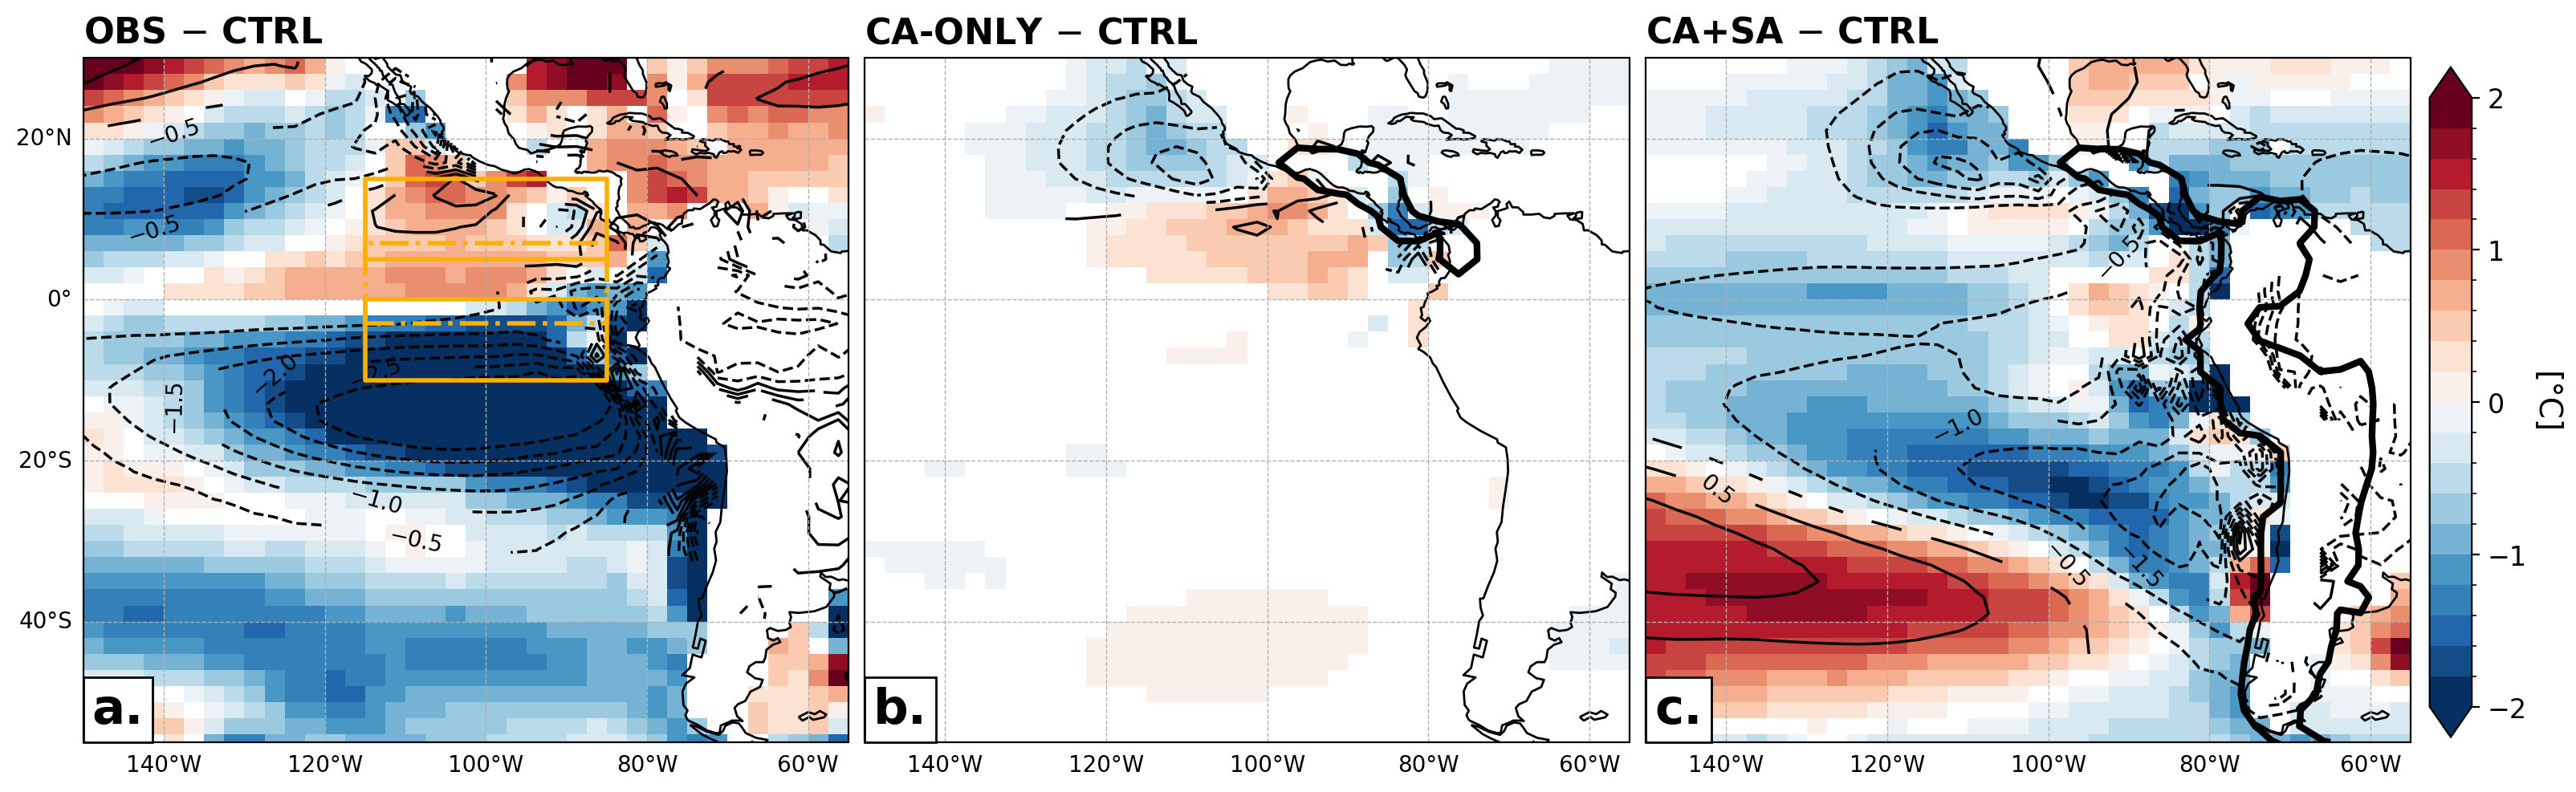

In [25]:
# -------------------- #
#       SETTINGS       #
# -------------------- #
# var info
varn = 'sst'
season = 'MAM'
# colormap specs
cmap=cm.RdBu_r
vmin=-2
vmax=2
levels=np.linspace(vmin, vmax, 21)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
# specific humidity contour levels
qlevels=np.linspace(-3,3,13)
# text specs
text_kw={'weight': 'bold','ha': 'left','va': 'bottom','color': 'black'}
# map specs
proj=ccrs.PlateCarree()
trans=ccrs.PlateCarree()
bounds=[-150., -55., -55., 30.]
# label coordinates
tx=-150
ty=31

# -------------------- #
#          FIG         #
# -------------------- #
fig,ax=plt.subplots(nrows=1, ncols=3, figsize=(15, 5), layout='constrained', subplot_kw={'projection': proj})

# CTRL
ax[0].text(tx,ty,'OBS $-$ CTRL', size=16, **text_kw)
ax[0].pcolormesh(lons, lats, diff_mask['obs'][varn][season], cmap=cmap, norm=norm, transform=trans)
cs1=ax[0].contour(lons, lats, diff_mask['obs']['q_925'][season], levels=qlevels, linewidths=1.25, colors='k', transform=trans)
ax[0].clabel(cs1, cs1.levels, inline=True, inline_spacing=-5, fontsize=10)

# boxes over region for averaging
lon_bnds = np.array([-115., -85, -85, -115.])
lat_bnds = np.array([15,  15,  5,  5])
ring=LinearRing(list(zip(lon_bnds, lat_bnds)))
ax[0].add_geometries([ring], crs=trans, fc='none', ec='#fcb001', lw=2, linestyle='-', zorder=11) 

lat_bnds = np.array([-10,  -10,  -0,  -0])
ring=LinearRing(list(zip(lon_bnds, lat_bnds)))
ax[0].add_geometries([ring], crs=trans, fc='none', ec='#fcb001', lw=2, linestyle='-', zorder=11) 

lat_bnds = np.array([-3,  -3,  7,  7])
ring=LinearRing(list(zip(lon_bnds, lat_bnds)))
ax[0].add_geometries([ring], crs=trans, fc='none', ec='#fcb001', lw=2, linestyle='-.', zorder=11) 


# CA-ONLY
ax[1].text(tx,ty,'CA-ONLY $-$ CTRL', size=16, **text_kw)
ax[1].pcolormesh(lons, lats, diff_mask['cam-only'][varn][season], cmap=cmap, norm=norm, transform=trans)
cs1=ax[1].contour(lons, lats, diff_mask['cam-only']['q_925'][season], levels=qlevels, linewidths=1.25, colors='k', transform=trans)
ax[1].clabel(cs1, cs1.levels, inline=True, inline_spacing=-5, fontsize=10)
ax[1].contour(lons, lats, c1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=10)

# CA+SA
ax[2].text(tx,ty,'CA+SA $-$ CTRL', size=16, **text_kw)
ax[2].pcolormesh(lons, lats, diff_mask['cam+sam'][varn][season], cmap=cmap, norm=norm, transform=trans)
cs1=ax[2].contour(lons, lats, diff_mask['cam+sam']['q_925'][season], levels=qlevels, linewidths=1.25, colors='k', transform=trans)
ax[2].clabel(cs1, cs1.levels, inline=True, inline_spacing=-5, fontsize=10)
ax[2].contour(lons, lats, cs1env_mask, colors='k', linewidths=3, levels=np.linspace(150,10000,2), transform=trans, zorder=10)

letters=['a.','b.','c.']
for i, ax in enumerate(ax.flat):
    ax.text(-148.9,-53.9, letters[i], size=22, **text_kw,
           bbox=dict(facecolor='white', edgecolor='black'))
    """
    # add IMERG climatology contours
    cs=ax.contour(lons, lats, obs.precip[mons].mean(dim='month'), levels=plevels, linewidths=.75, colors='fuchsia', transform=trans, zorder=100)
    ax.clabel(cs, cs.levels, inline=True, inline_spacing=0, fontsize=8)
    """
    # map properties
    ax.coastlines(color='k')
    #ax.add_feature(cfeature.LAND, fc='silver', zorder=5)
    ax.set_extent(bounds, crs=trans)
    gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    if i==0:
        gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
    if i in [1,2]:
        gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
        
# add colorbar
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([1.005, 0.08, 0.0175, 0.835])
cbar=fig.colorbar(cf, ticks=[-2,-1,0,1,2], orientation='vertical', extend='both', cax=cax)
cbar.set_label('[°C]', labelpad=15, rotation=270, size=14, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=12)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
plt.savefig(f'sst.q925.cpld.{season}.masked.boxes.pdf', transparent=True, bbox_inches='tight')